In [1]:
import os
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)
print(os.getcwd())

/home/oded/TimeOperator


In [2]:
from src.configs import NAVIER_STOKES_CONFIGS
from src.utils.architecture_builder import build_archtitecture
from src.utils.utils import (get_logger, count_params)
from src.ditto.data_loader import DataHandler
import torch
import numpy as np
from tqdm import tqdm

model_name = "ditto_subsampled_X10"
logger = get_logger()
model_path = os.path.join("src", "outputs", "models", "navier_stokes", "ditto_subsampled_X10", "NavierStokes_v_0.001_N_1000_T_50_nx_64_ny_64_time_steps_50.pth")
config = NAVIER_STOKES_CONFIGS
config.N = 100
config.time_steps_inference = 50
model = build_archtitecture(model_type="ditto_subsampled_X10", configs=config, logger=logger, mode="test")

2024-04-13 13:39:58 Using Unet2D


In [3]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [4]:
os.chdir(os.path.join("src", "ditto"))
print(os.getcwd())
reader = DataHandler(configs=config, model_name=model_name, logger=logger)
train_loader, val_loader, test_loader = reader.load_data()
os.chdir(os.path.join("..", ".."))
print(os.getcwd())

2024-04-13 13:39:58 Loading data from ../data/navier_stokes/NavierStokes_v_0.001_N_100_T_50_nx_64_ny_64
2024-04-13 13:39:58 Current working dir: /home/oded/TimeOperator/src/ditto
2024-04-13 13:39:58 Shape x: (100, 64, 64)
2024-04-13 13:39:58 Shape y: (100, 64, 64, 200)


/home/oded/TimeOperator/src/ditto


2024-04-13 13:40:01 --------------------------------------------------
2024-04-13 13:40:01 Shapes after preprocessing:
2024-04-13 13:40:01 Shape x_train: torch.Size([14480, 1, 64, 64])
2024-04-13 13:40:01 Shape y_train: torch.Size([14480, 21, 64, 64])
2024-04-13 13:40:01 Shape x_val: torch.Size([10, 1, 64, 64])
2024-04-13 13:40:01 Shape y_val: torch.Size([10, 201, 64, 64])
2024-04-13 13:40:01 Shape x_test: torch.Size([10, 1, 64, 64])
2024-04-13 13:40:01 Shape y_test: torch.Size([10, 201, 64, 64])
2024-04-13 13:40:01 Shape t_train: torch.Size([14480, 21])
2024-04-13 13:40:01 Shape t_val: torch.Size([10, 21])
2024-04-13 13:40:01 Shape t_test: torch.Size([10, 21])
2024-04-13 13:40:01 Done loading data


/home/oded/TimeOperator


In [5]:
batch_count = 0
x_list = []
t_list = []
y_true_list = []
for x, t, y_true in tqdm(test_loader):
    x, t, y_true = x.cuda(), t.cuda(), y_true.cuda()
    x_list.append(x)
    t_list.append(t)
    y_true_list.append(y_true)
    batch_count += 1
    if batch_count == 5:
        break

x = torch.cat(x_list, dim=0)
t = torch.cat(t_list, dim=0)
y_true = torch.cat(y_true_list, dim=0)

100%|██████████| 1/1 [00:00<00:00, 95.11it/s]


In [6]:
x.shape, t.shape, y_true.shape

(torch.Size([10, 1, 64, 64]),
 torch.Size([10, 1, 21]),
 torch.Size([10, 201, 64, 64]))

In [7]:
import matplotlib.pyplot as plt

def plot_2d(y, out, save=False):
    fig, ax = plt.subplots(3, out.shape[2], figsize=(5 * out.shape[2], 10))
    for t in range(out.shape[2]):
        ax[0, t].imshow(y[0, 0, t, ...].cpu().detach(), cmap="twilight")
        ax[1, t].imshow(out[0, 0, t, ...].cpu().detach(), cmap="twilight")
        ax[2, t].imshow(torch.abs(y[0, 0, t, ...] - out[0, 0, t, ...]).cpu().detach(), cmap="twilight")
        l2_error = torch.norm(y[0, 0, t, ...] - out[0, 0, t, ...]) / torch.norm(y[0, 0, t, ...])
        ax[0, t].set_title(f"True: {t}")
        ax[1, t].set_title(f"Pred: {t}")     
        ax[2, t].set_title(f"L2: {l2_error:.2e}")
    
    if save:
        plt.savefig("compare.png")
    plt.show()

TypeError: Invalid shape (201, 64, 64) for image data

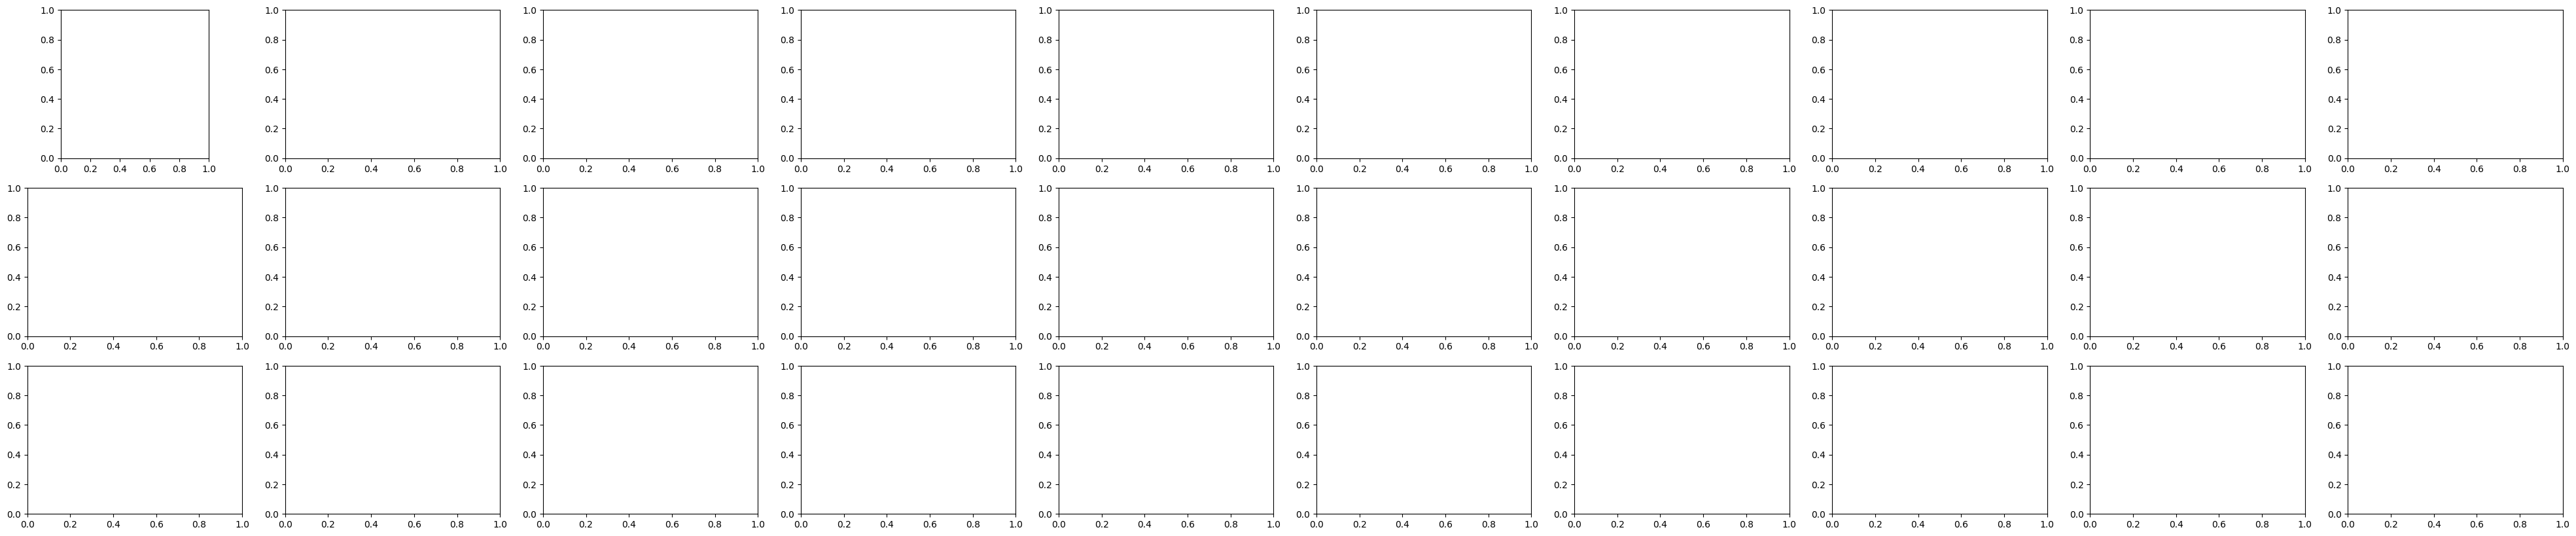

In [8]:
# plot_2d(y_true[None, None, ::1, ...], y_true[None, None, ::1, ...])

In [9]:
y_true.shape

torch.Size([10, 201, 64, 64])

In [11]:
t.shape

torch.Size([10, 1, 21])

In [ ]:
import pandas as pd
model.load_state_dict(torch.load(model_path))

errors_dict = {
    "Rel L2 vs pred": 
    {
        'ditto_1dt': [],
        'ditto_2dt': [],
        'self_ditto_2dt': [],
        'iterative_ditto_2dt': []
    },
    "Rel L2 vs true": {
        'ditto_1dt': [],
        'ditto_2dt': [],
        'self_ditto_2dt': [],
        'iterative_ditto_2dt': []
    }
}

with torch.no_grad():
    y_pred = model(x, t)
    
    ditto_1dt_list = []
    ditto_2dt_list = []
    self_ditto_2dt_list = []
    iterative_ditto_2dt_list = []
    y_pred_list = []
    y_true_list = []

    for j in tqdm(range(50)):
        # Consistency check
        ditto_1dt = model(x[j:j+1], t[j:j+1])  # Equiv to y_pred[0:1, ...]

        if j < 49:
            ditto_2dt = model(x[j:j+1], t[j+1:j+2])  # Equiv to y_pred[1:2, ...]
            self_ditto_2dt = model(ditto_1dt, t[0:1])  # Equiv to y_pred[1:2, ...]
            iterative_ditto_2dt = model(y_true[j:j+1, None, ...], t[0:1])  # Equiv to y_pred[1:2, ...]

        # Fix shapes
        ditto_1dt = ditto_1dt[0, 0, ...]
        y_pred_j = y_pred[j, 0, ...]

        if j < 49:
            ditto_2dt = ditto_2dt[0, 0, ...]
            self_ditto_2dt = self_ditto_2dt[0, 0, ...]
            iterative_ditto_2dt = iterative_ditto_2dt[0, 0, ...]

        # Append to list
        ditto_1dt_list.append(ditto_1dt)
        y_pred_list.append(y_pred_j)

        if j < 49:
            ditto_2dt_list.append(ditto_2dt)
            self_ditto_2dt_list.append(self_ditto_2dt)
            iterative_ditto_2dt_list.append(iterative_ditto_2dt)

        # Compute l2 errors
        if j < 49:
            errors_dict["Rel L2 vs pred"]["ditto_1dt"].append((torch.norm(ditto_1dt - y_pred_j) / torch.norm(y_pred_j)).item())
            errors_dict["Rel L2 vs pred"]["ditto_2dt"].append((torch.norm(ditto_2dt - y_pred[j+1, 0, ...]) / torch.norm(y_pred[j+1, 0, ...])).item())
            errors_dict["Rel L2 vs pred"]["self_ditto_2dt"].append((torch.norm(self_ditto_2dt - y_pred[j+1, 0, ...]) / torch.norm(y_pred[j+1, 0, ...])).item())
            errors_dict["Rel L2 vs pred"]["iterative_ditto_2dt"].append((torch.norm(iterative_ditto_2dt - y_pred[j+1, 0, ...]) / torch.norm(y_pred[j+1, 0, ...])).item())


    # Concatenate all
    ditto_1dt = torch.stack(ditto_1dt_list, dim=0)
    ditto_2dt = torch.stack(ditto_2dt_list, dim=0)
    self_ditto_2dt = torch.stack(self_ditto_2dt_list, dim=0)
    iterative_ditto_2dt = torch.stack(iterative_ditto_2dt_list, dim=0)
    y_pred = torch.stack(y_pred_list, dim=0)

    print(f"ditto_1dt: {ditto_1dt.shape}")
    print(f"ditto_2dt: {ditto_2dt.shape}")
    print(f"self_ditto_2dt: {self_ditto_2dt.shape}")
    print(f"iterative_ditto_2dt: {iterative_ditto_2dt.shape}")
    print(f"y_pred: {y_pred.shape}")
    print(f"y_true: {y_true.shape}")


    # Aggregate all errors by taking the mean l2 error over j
    y_true_shifted = y_true[1:, ...]
    y_pred_shifted = y_pred[1:, ...]

    # errors_dict = {
    #     "Rel L2 vs pred": 
    #     {
    #         'ditto_1dt': torch.mean(torch.norm(ditto_1dt - y_pred, dim=(1, 2)) / torch.norm(y_pred, dim=(1, 2))).item(),
    #         'ditto_2dt': torch.mean(torch.norm(ditto_2dt - y_pred_shifted, dim=(1, 2)) / torch.norm(y_pred_shifted, dim=(1, 2))).item(),
    #         'self_ditto_2dt': torch.mean(torch.norm(self_ditto_2dt - y_pred_shifted, dim=(1, 2)) / torch.norm(y_pred_shifted, dim=(1, 2))).item(),
    #         'iterative_ditto_2dt': torch.mean(torch.norm(iterative_ditto_2dt - y_pred_shifted, dim=(1, 2)) / torch.norm(y_pred_shifted, dim=(1, 2))).item()
    #     },
    #     "Rel L2 vs true": {
    #         'ditto_1dt': torch.mean(torch.norm(ditto_1dt - y_true, dim=(1, 2)) / torch.norm(y_true, dim=(1, 2))).item(),
    #         'ditto_2dt': torch.mean(torch.norm(ditto_2dt - y_true_shifted, dim=(1, 2)) / torch.norm(y_true_shifted, dim=(1, 2))).item(),
    #         'self_ditto_2dt': torch.mean(torch.norm(self_ditto_2dt - y_true_shifted, dim=(1, 2)) / torch.norm(y_true_shifted, dim=(1, 2))).item(),
    #         'iterative_ditto_2dt': torch.mean(torch.norm(iterative_ditto_2dt - y_true_shifted, dim=(1, 2)) / torch.norm(y_true_shifted, dim=(1, 2))).item()
    #     }

    # }
# pd.DataFrame(errors_dict).T

In [ ]:
pd.DataFrame(errors_dict["Rel L2 vs pred"]).plot()

In [ ]:
plot_2d(self_ditto_2dt[None, None, ...], y_true_shifted[None, None, ...])

In [ ]:
plot_2d(ditto_1dt[None, None, ...], y_true[None, None, ...])

In [ ]:
for i in range(49):
    # l2_error = torch.norm(ditto_1dt[i, ...] - y_true_truncated[i, ...]) / torch.norm(y_true_truncated[i, ...])
    l2_error = torch.norm(self_ditto_2dt[i, ...] - y_true[i + 1, ...]) / torch.norm(y_true[i + 1, ...])
    print(l2_error.item())